In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
import glob

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [ ]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import os
from glob import glob

data_path = '/content/drive/MyDrive/Noisy image/'
# print("no of data in each class:",len(os.listdir(data_path)))
print(os.listdir(data_path))

['Salt and pepper', 'Poisson', 'Motion artifact', 'Gaussian']


In [ ]:
#### Creating Dataset folders ####
import shutil

ratio = 0.7

for file in os.listdir(data_path):
  
  ### Randomly Selecting ###
  file_path = data_path+file
  print(file)
  imgs_path = glob(file_path + '/*')
  
  print(len(imgs_path))
  np.random.shuffle(imgs_path)
  train_imgs_path, test_imgs_path = np.split(np.array(imgs_path),[int(len(imgs_path)*ratio)])
  print(len(train_imgs_path),len(test_imgs_path))

  # train_path = '/content/drive/MyDrive/Noise_Dataset/train/'
  # target_path = train_path + file
  # for train_img_path in train_imgs_path:
  #   shutil.copy2(train_img_path, target_path)

  # print(len(os.listdir(target_path)))

  # test_path = '/content/drive/MyDrive/Noise_Dataset/test/'
  # target_path = test_path + file
  # for test_img_path in test_imgs_path:
  #   shutil.copy2(test_img_path, target_path)

  # print(len(os.listdir(target_path)))

Salt and pepper
225
157 68
Poisson
225
157 68
Motion artifact
225
157 68
Gaussian
225
157 68


In [ ]:
##### Data Augmentation ######

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = '/content/drive/MyDrive/Noise_Dataset/train/'
test_path = '/content/drive/MyDrive/Noise_Dataset/test/'

IMAGE_SIZE=[224,224,3]
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  #  shear_range = 0.2,
                                  #  zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = False,
                                   data_format = 'channels_last',
                                   dtype = tf.float32)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (IMAGE_SIZE[0], IMAGE_SIZE[1]),
                                                 batch_size = 36, # Entire Dataset
                                                 color_mode = 'rgb',
                                                 class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (IMAGE_SIZE[0], IMAGE_SIZE[1]),
                                            batch_size = 14,
                                            color_mode = 'rgb',
                                            class_mode = 'categorical')


Found 628 images belonging to 4 classes.
Found 272 images belonging to 4 classes.


(36, 224, 224, 3)
(36, 4)
[0. 0. 0. 1.]


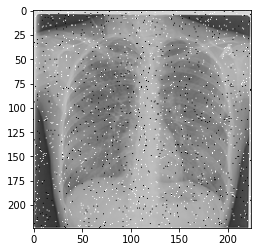

In [ ]:
x,y = training_set[0]
print(x.shape)
print(y.shape)

idx = 15
plt.imshow(x[idx])
print(y[idx])

In [ ]:
######## Getting Data in Array Format ##########
n_batches = len(training_set)
X_train = np.concatenate([training_set[i][0] for i in range(n_batches)])
Y_train = np.concatenate([training_set[i][1] for i in range(n_batches)])
print(X_train.shape)
print(Y_train.shape)

n_batches = len(test_set)
X_test = np.concatenate([test_set[i][0] for i in range(n_batches)])
Y_test = np.concatenate([test_set[i][1] for i in range(n_batches)])
print(X_test.shape)
print(Y_test.shape)

(628, 224, 224, 3)
(628, 4)
(272, 224, 224, 3)
(272, 4)


In [ ]:
print(len(training_set))

18


1. VGG16 Model

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

vgg16 = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
for layer in vgg16.layers:
    layer.trainable = False
x = Flatten()(vgg16.output)

prediction = Dense(4, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    name="Adam"),
  metrics=['accuracy']
)

In [ ]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
18/18 [==============================] - 64s 872ms/step - loss: 1.0608 - accuracy: 0.5410 - val_loss: 0.3801 - val_accuracy: 0.8272
Epoch 2/20
18/18 [==============================] - 7s 430ms/step - loss: 0.2398 - accuracy: 0.9355 - val_loss: 0.1863 - val_accuracy: 0.9485
Epoch 3/20
18/18 [==============================] - 8s 450ms/step - loss: 0.1259 - accuracy: 0.9736 - val_loss: 0.1234 - val_accuracy: 0.9853
Epoch 4/20
18/18 [==============================] - 8s 452ms/step - loss: 0.0848 - accuracy: 0.9921 - val_loss: 0.1029 - val_accuracy: 0.9779
Epoch 5/20
18/18 [==============================] - 8s 441ms/step - loss: 0.0586 - accuracy: 0.9955 - val_loss: 0.0878 - val_accuracy: 0.9743
Epoch 6/20
18/18 [==============================] - 7s 423ms/step - loss: 0.0609 - accuracy: 0.9941 - val_loss: 0.1037 - val_accuracy: 0.9632
Epoch 7/20
18/18 [==============================] - 7s 424ms/step - loss: 0.0439 - accuracy: 0.9949 - val_loss: 0.0655 - val_accuracy: 0.9853
Epoch

In [ ]:
model.save('saved_models/vgg16_noise') 

INFO:tensorflow:Assets written to: saved_models/vgg16_noise/assets


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/models/vgg16_noise')

In [ ]:
from sklearn import metrics
new_model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    name="Adam"),
  metrics=['accuracy',
           'AUC',
           'Precision',
           'Recall',
  ]
)

In [ ]:
results = new_model.evaluate(test_set)
print(results)

20/20 [==============================] - 3s 117ms/step - loss: 0.0487 - accuracy: 0.9853 - auc: 0.9991 - precision: 0.9889 - recall: 0.9853
[0.04871130362153053, 0.9852941036224365, 0.9990786910057068, 0.9889298677444458, 0.9852941036224365]


In [ ]:
y_prediction = new_model.predict(test_set)
# print(y_prediction.shape)

y_classes = y_prediction.argmax(axis=1)
print(y_classes.shape)
print(y_classes)
print(test_set.classes.shape)
print(test_set.classes)

(272,)
[1 0 2 0 3 1 1 0 0 2 3 3 1 2 2 3 0 1 3 1 3 1 1 0 2 1 1 0 1 3 0 0 2 0 2 3 0
 0 0 2 1 2 0 0 1 3 0 1 2 3 3 1 1 2 0 3 3 1 1 2 1 2 0 1 0 3 3 3 3 1 1 3 1 3
 0 1 3 3 0 1 0 1 1 2 2 2 3 2 3 1 1 2 2 1 3 0 1 3 1 2 3 3 3 1 2 1 2 1 1 2 2
 3 3 0 1 1 3 0 1 0 1 2 0 2 1 2 2 3 3 1 2 1 2 0 1 1 0 3 1 3 3 1 1 1 0 1 0 1
 3 0 0 3 1 3 0 0 2 3 1 0 0 1 1 1 2 2 1 0 3 2 0 2 0 2 2 2 0 0 2 0 3 2 0 0 1
 3 2 2 3 1 1 3 3 0 0 0 2 2 2 3 2 1 0 0 0 0 3 2 2 3 2 0 3 3 0 3 2 3 2 3 3 3
 3 1 1 3 0 0 3 3 2 2 0 2 0 3 1 2 2 1 0 3 2 1 0 3 2 0 2 1 2 0 0 3 3 0 1 3 3
 2 2 2 2 1 1 3 1 2 2 2 0 1]
(272,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print('Confusion Matrix:')
print(confusion_matrix(test_set.classes, y_classes))

print("Accuracy : " ,accuracy_score(test_set.classes, y_classes))
print("Precision : " ,precision_score(test_set.classes, y_classes,average='micro'))
print("Recall : " ,recall_score(test_set.classes, y_classes,average = 'micro'))
print("F1 Score : " ,f1_score(test_set.classes, y_classes,average = 'micro'))

Confusion Matrix:
[[19 20 13 16]
 [ 9 25 17 17]
 [22 16 16 14]
 [15 11 21 21]]
Accuracy :  0.2977941176470588
Precision :  0.2977941176470588
Recall :  0.2977941176470588
F1 Score :  0.2977941176470588


In [ ]:
y_pred = new_model.predict(X_test)
y_classes = np.argmax(y_pred,axis=-1)

y_act = np.argmax(Y_test,axis=1)

print(y_classes.shape,y_act.shape)

(272,) (272,)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print('Confusion Matrix:')
print(confusion_matrix(y_act, y_classes))

print("Accuracy : " ,accuracy_score(y_act, y_classes))
print("Precision : " ,precision_score(y_act, y_classes,average='micro'))
print("Recall : " ,recall_score(y_act, y_classes,average = 'micro'))
print("F1 Score : " ,f1_score(y_act, y_classes,average = 'micro'))

Confusion Matrix:
[[65  3  0  0]
 [ 0 68  0  0]
 [ 0  1 67  0]
 [ 0  0  0 68]]
Accuracy :  0.9852941176470589
Precision :  0.9852941176470589
Recall :  0.9852941176470589
F1 Score :  0.9852941176470589


In [ ]:
import matplotlib.pyplot as plt

def eval(model, opti, epcs, training_set, test_set):

  model.compile(optimizer = opti, loss = 'categorical_crossentropy', metrics = ['accuracy'])

  log = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=epcs,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
  )

  plt.figure(figsize = (12,8))
  plt.subplot(1,2,1)
  plt.plot(log.history['loss'])
  plt.plot(log.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  
  plt.subplot(1,2,2)
  plt.plot(log.history['accuracy'])
  plt.plot(log.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')

In [ ]:
######### CNN models #########

### For VGG16 Model ###
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet101

IMAGE_SIZE=[224,224,3]

def model_vgg16(summary = False, classes = 4):

  vgg19 = VGG19(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
  for layer in vgg19.layers:
    layer.trainable = False

  x = Flatten()(vgg19.output)
  prediction = Dense(classes, activation='softmax')(x)

  # create a model object
  model = Model(inputs=vgg19.input, outputs=prediction)
  if summary == True:
    model.summary()
  else:
    pass
  
  return model

def model_resnet(summary = False, classes = 4):
  resnet=ResNet101(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
  for layer in resnet.layers:
    layer.trainable=False

  x = Flatten()(resnet.output)
  prediction = Dense(classes, activation='softmax')(x)

  # create a model object
  model = Model(inputs=resnet.input, outputs=prediction)
  if summary == True:
    model.summary()
  else:
    pass
  
  return model

80150528/80134624 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
18/18 [==============================] - 564s 30s/step - loss: 1.2767 - accuracy: 0.5415 - val_loss: 0.3628 - val_accuracy: 0.9081
Epoch 2/10
18/18 [==============================] - 11s 600ms/step - loss: 0.2583 - accuracy: 0.9168 - val_loss: 0.1943 - val_accuracy: 0.9522
Epoch 3/10
18/18 [==============================] - 11s 601ms/step - loss: 0.0912 - accuracy: 0.9828 - val_loss: 0.2317 - val_accuracy: 0.9375
Epoch 4/10
18/18 [==============================] - 10s 592ms/step - loss: 0.0687 - accuracy: 0.9808 - val_loss: 0.0860 - val_accuracy: 0.9779
Epoch 5/10
18/18 [==============================] - 11s 599ms/step - loss: 0.0451 - accuracy: 0.9880 - val_loss: 0.1429 - val_accuracy: 0.9559
Epoch 6/10
18/18 [==============================] - 11s 600ms/step - loss: 0.0274 - accuracy: 0.9956 - val_loss: 0.0438 - val_accuracy: 0.9853
Epoch 7/10
18/18 [==============================] - 11s 601ms/step - loss: 0.0282 - accuracy: 0.9978 - val_loss: 0.0653 - val_accuracy: 0.9816


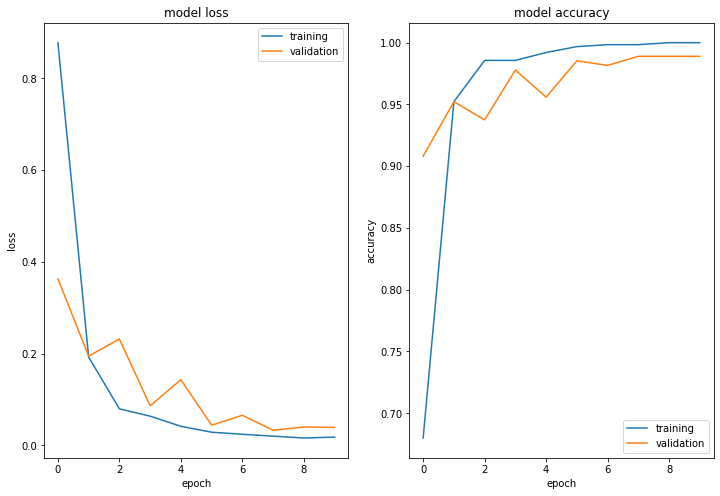

In [ ]:
model = model_vgg16(False,len(os.listdir(data_path)))
eval(model,'adam', 10, training_set, test_set)

In [ ]:
y_test_pred = model.predict(test_set)

In [ ]:

y_test_pred = model.predict_proba(test_set)


171458560/171446536 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
18/18 [==============================] - 38s 960ms/step - loss: 4.1919 - accuracy: 0.3356 - val_loss: 2.8231 - val_accuracy: 0.4816
Epoch 2/40
18/18 [==============================] - 8s 486ms/step - loss: 2.1123 - accuracy: 0.4431 - val_loss: 1.1568 - val_accuracy: 0.4375
Epoch 3/40
18/18 [==============================] - 8s 487ms/step - loss: 1.2470 - accuracy: 0.5071 - val_loss: 0.7633 - val_accuracy: 0.6471
Epoch 4/40
18/18 [==============================] - 8s 454ms/step - loss: 0.7842 - accuracy: 0.6576 - val_loss: 0.5857 - val_accuracy: 0.7132
Epoch 5/40
18/18 [==============================] - 8s 460ms/step - loss: 0.6384 - accuracy: 0.7225 - val_loss: 0.6548 - val_accuracy: 0.6140
Epoch 6/40
18/18 [==============================] - 8s 457ms/step - loss: 0.6311 - accuracy: 0.7071 - val_loss: 0.4785 - val_accuracy: 0.8346
Epoch 7/40
18/18 [==============================] - 8s 459ms/step - loss: 0.5454 - accuracy: 0.7733 - val_loss: 0.4404 - val_accuracy: 0.9412
Epoch

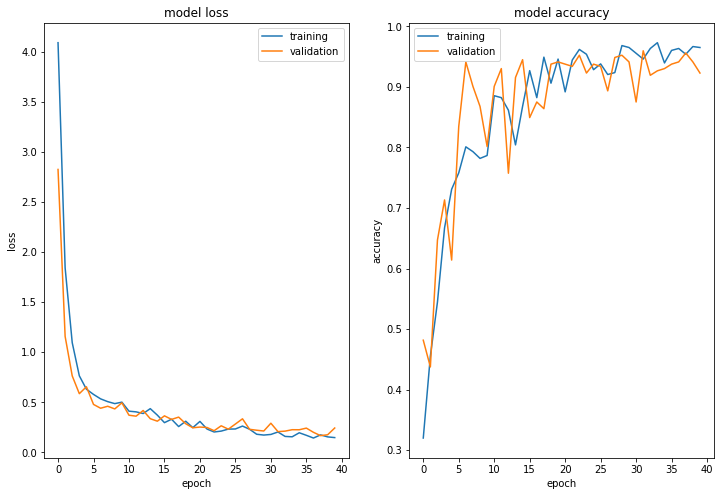

In [ ]:
model = model_resnet(False,len(os.listdir(data_path)))
eval(model,'adam', 40, training_set, test_set)